# Projeto Recommender System: Movies

Esse projeto tem como finalidade explorar alguns métodos sobre sistema de recomendação. A proposta é criarmos um sistema de recomendação simples utilizando o algoritmo de Recomendação Colaborativa. O ponto de partida é o artigo [Toward the Next Generation of Recommender Systems: A Survey of the State-of-the-Art and Possible Extensions](http://ieeexplore.ieee.org/document/1423975/). Vamos implementar uma das propostas de recomendação colaborativa do artigo. Detalhes do método implementado é dado mais a frente.

Esse tutorial é dividido em: 

* [Dataset](#dataset)
* [Descrição do Método de Recomendação](#descricao)
* [Métodos Auxiliares](#metodosauxiliares)
* [Sistema De Recomendação Simples](#rs_simple)
* [Sistema de Recomendação Colaborativo](#rs_collaborative)
* [Usando a API do IMDb](#imdb)
* [Atividade do MiniProjeto](#atividade)

<a id='dataset'></a>
## Dataset

Para demostrar os algoritmos de recomendação vamos utilizar o dataset da *[MovieLens](https://grouplens.org/datasets/movielens/)*.  O site possui varias versões do dataset cada qual com um número diferentes de filmes e usuários. Vamos utilizar a versão *small* deles que é descrita como segue: 

> **MovieLens Latest Datasets**

> These datasets will change over time, and are not appropriate for reporting research results. We will keep the download links stable for automated downloads. We will not archive or make available previously released versions.

> Small: 100,000 ratings and 1,300 tag applications applied to 9,000 movies by 700 users. Last updated 10/2016.

A primeira etapa é carregar a base de dados como vários DataFrames do Pandas. 

Vamos carregar 4 arquivos: 

* **links:** possui referência do id de cada filme para o id na base do [IMDb](http://www.imdb.com/) e na base do [TheMovieDb](http://www.themoviedb.org). Essa informação será usada no final para exibir mais informações dos filmes recomendados utilizando as APIs disponibilizadas por estes sites.
* **movies:** lista de filmes da base. Cada filme possui o título e uma lista de gêneros associada.
* **ratings:** tabela de avaliação de filmes. Cada usuário avalia um filme com uma nota de 1 a 5. É armazenado também o *timestamp* de cada avaliação.
* **tags:** termos associados a cada filme cadastrados pelos usuários.

Para este tutorial vamos utilizar somente as três primeiras tabelas.

In [13]:
# Import necessários para esta seção
import pandas as pd
idx = pd.IndexSlice

In [2]:
# Preparando o Dataset

links = pd.read_csv("../datasets/movielens/links.csv",  index_col=['movieId'])
movies = pd.read_csv("../datasets/movielens/movies.csv", sep=",", index_col=['movieId'])
ratings = pd.read_csv("../datasets/movielens/ratings.csv", index_col=['userId','movieId'])
tags = pd.read_csv("../datasets/movielens/tags.csv", index_col=['userId','movieId'])

In [3]:
ratings.head()

rating   timestamp
userId movieId                    
1      31          2.5  1260759144
       1029        3.0  1260759179
       1061        3.0  1260759182
       1129        2.0  1260759185
       1172        4.0  1260759205

<a id='descricao'></a>
## Descrição do Método de Recomendação

Como dito anteriormente, vamos utilizar um método de recomendação apresentada no artigo [Toward the Next Generation of Recommender Systems: A Survey of the State-of-the-Art and Possible Extensions](http://ieeexplore.ieee.org/document/1423975/). Existem [vários tipos de sistemas de recomendação](https://www.bluepiit.com/blog/classifying-recommender-systems/), neste tutorial vamos utilizar a recomendação dita colaborativa. Esse titpo de recomendação utiliza a avaliação do usuário (*ratings*) para recomendar. Os usuários são comparados entre si, utilizando alguma métrica de similaridade, e a recomendação é proposta tomando como base os *ratings* dos usuários mais semelhantes. A recomendação é medida a partir da predição da nota que usuário daria a um determinado item (*predict rating*)

Duas métricas precisam ser definidas: 

* O cálculo da similaridade de usuários
* O cálculo do *predict rating*

Vamos utilizar as seguintes equações propostas no artigo: 

### Cáculo da Similaridade

$ sim(x,y) = \frac{\sum_{
    s \in S_{xy}}
    {
        (r_{x,s} - \bar{r_{x}})
        (r_{y,s} - \bar{r_{y}})
    }
}
{
    \sqrt{
        \sum_{s \in S_{xy}}{
            (r_{x,s} - \bar{r_{x}})^2
        }
        \sum_{s \in S_{xy}}{
            (r_{y,s} - \bar{r_{y}})^2
        }
    }
} $, onde:

* $S_x$: itens avaliados pelo usuário $x$;
* $S_y$: itens avaliados pelo usuário $y$;
* $S_{xy}$: o conjunto de todos os itens que foram avaliados tanto por x quanto por y, em outras palavras, a interseção dos conjuntos $S_x$ e $S_y$;
* $r_{x,s}$: *rating* do usuário $x$ para o item $s$;
* $r_{y,s}$: *rating* do usuário $y$ para o item $s$;
* $\bar{r_x}$: média do *ratings* dos filmes avaliados por $x$
* $\bar{r_y}$: média do *ratings* dos filmes avaliados por $y$

### O cálculo do *predict rating*

Para cada filme da base que o usuário não avaliou é calculado um valor de *rating* que o usuário daria ao filme. A proposta é calcular isto para todos os filmes da base e recomendar ao usuário os 10 filmes mais bem avaliados. Para este cálculo vamos utilizar a equação: 

$ r_{c,s} = \bar{r_c} + k * \sum_{c' \in \hat{C}}{sim(c,c') \times (r_{c',s} - \bar{r_{c'}})}$, onde:

* $c$ e $c'$: são usuários;
* $s$: um item;
* $k$: é um fator noramlizador dado por $k = \frac{1}{\sum_{c' \in \hat{C}}{|sim(c, c')|}}$
* $sim(c, c'):$ a similaridade do usuário c com o usuário c' dada pela equação anterior;
* $\hat{C}:$ o conjunto dos $N$ usuários mais similares a $c$ que avaliaram o item $s$.

as demais variáveis forma descritas na equação anterior, mudando apenas as letras utilizadas. 



<a id='metodosauxiliares'></a>
## Métodos Auxiliares

Para facilitar a implementação das duas equações, vamos implementar uma série de métodos auxiliares que vão nos ajudar a extrair as informações da base de dados. O código a seguir implementa tais métodos. O que cada método faz está descrito no início de cada um. 

In [15]:
def get_movies_by_user(id_user, rating_cut=0, list_=False):
    
    """Retorna a lista de filmes avaliados por um usuário

    Keyword arguments:
    id_user -- id do usuário
    rating_cut -- retorna só itens avaliados com rating maior que rating_cut (default: 0)
    list_ -- se True retorna somente os ids dos filmes, se False retorna os ids com o valor do rating (default: False)
    
    """

    
    return_dict = {}
    dict_ = ratings.loc[idx[id_user, :], 'rating'].T.to_dict()
    
    for d in dict_:
        if rating_cut != 0:
            if dict_[d] >= rating_cut:
                return_dict[d[1]] = dict_[d]
        else:
            return_dict[d[1]] = dict_[d]
    
    if list_:
        return list(return_dict.keys())

    return return_dict

def get_users_by_movie(id_movie, rating_cut=0, list_=False):
    
    """Retorna a lista de usuários que avaliaram determinado filme

    Keyword arguments:
    id_movie -- id do filme
    rating_cut -- retorna só usuários que avaliaram o filme com rating maior que rating_cut (default: 0)
    list_ -- se True retorna somente os ids dos usuários, se False retorna os ids com o valor do rating
    
    """
    
    return_dict = {}
    dict_ = ratings.loc[idx[:, id_movie],'rating'].T.to_dict()
    for d in dict_:
        if rating_cut != 0:
            if dict_[d] >= rating_cut:
                return_dict[d[0]] = dict_[d]
        else:
            return_dict[d[0]] = dict_[d]
        
    if list_:
        return list(return_dict.keys())
    
    return return_dict


def get_rating_by_user_movie(id_user, id_movie):
    
    """Retorna o rating que o usuário (id_user) deu para um filme (id_movie). Se não exister, retorna 0.0.

    Keyword arguments:
    id_user -- id do usuário
    id_movie -- id do filme
    
    """
    
    rating = 0.0;
    
    try:
        rating = ratings.loc[idx[id_user, id_movie], 'rating']
    except KeyError as e:
        rating = 0.0

    return rating

def get_all_users():
    
    """Retorna o id de todos os usuários.
    
    """
    
    return list(set([x[0] for x in ratings.index.values]))

def get_movie_title(id_movie):
    
    """Retorna o título de um filme.

    Keyword arguments:
    id_movie -- id do filme
    
    """
    
    info = movies.loc[idx[id_movie], :]
    return info['title']

Mesmo com esses métodos algumas operações podem ter um certo custo computacional já que serão chamadas várias vezes. Por exemplo, quando vamos calcular a similaridade de um usuário com todos da base, isso tem um certo custo. Por conta disso, algumas informações serão geradas antes e armazenadas em variáveis na memória. Tais informações serão geradas nas células a seguir. Essas variáveis só serão utilizadas nos métodos em que são utilizadas muitas vezes. 

In [16]:
'''
    Neste trecho vamos armazenar em memória as informações de filmes avaliados pelos usuários. Isso evitar 
    fazermos muitos acesso a estrutura do DataFrame. 
'''

all_users = get_all_users()

movies_user_true = {}
movies_user_false = {}

for user in all_users:
    movies_user_true[user] = get_movies_by_user(user, list_=True)
    movies_user_false[user] = get_movies_by_user(user, list_=False)

<a id='rs_simple'></a>
## Sistema De Recomendação Simples

Só para que a gente veja alguns desses métodos funcionando, vamos implementar um "Sistema de Recomendação" bem simples. A proposta é recomendar os filmes avaliados com nota 5 que foram assistidos por usuários que já assistiram os mesmos filmes com nota 4 e 5 do usuário em questão. 

In [17]:
# Usuário para qual a recomendação será apresentada, chamarei de usuário A  
selected_user = 1

# Filmes com notas 4 e 5 avaliados por este usuário
my_movies = get_movies_by_user(selected_user, rating_cut=4, list_=True)


# Lista de todos os usuários que avaliaram os filmes assistidos por A
all_users = []

for movie in my_movies:
    all_users = all_users + get_users_by_movie(movie, rating_cut=5, list_=True)

# Para eliminar os usuários repetidos, transformamos a lista em um conjunto e depois convertemos novamente em uma lista
all_users = list(set(all_users))


# Neste passo, pegamos todos os filmes nota 5 avaliados pelos usuários de all_users
all_movies = []

for user in all_users:
    movies_ = get_movies_by_user(user, rating_cut=5, list_=True)
    all_movies = all_movies + movies_
    
# Removemos os filmes repetidos e aqueles já assistidos por A     
all_movies = list(set(all_movies) - set(my_movies))

# Apresentamos a lista dos filmes 
print("Foram encontrados: " + str(len(all_movies)) + " filmes")
for movie in all_movies:
    print("\t"+ get_movie_title(movie))


Foram encontrados: 1106 filmes
	Toy Story (1995)
	Hiroshima Mon Amour (1959)
	Heat (1995)
	Sabrina (1995)
	American President, The (1995)
	Fighter, The (2010)
	Casino (1995)
	Sense and Sensibility (1995)
	Get Shorty (1995)
	Leaving Las Vegas (1995)
	Persuasion (1995)
	City of Lost Children, The (Cité des enfants perdus, La) (1995)
	Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
	Babe (1995)
	Carrington (1995)
	Dead Man Walking (1995)
	Clueless (1995)
	Richard III (1995)
	Seven (a.k.a. Se7en) (1995)
	Viridiana (1961)
	Usual Suspects, The (1995)
	Postman, The (Postino, Il) (1994)
	Confessional, The (Confessionnal, Le) (1995)
	Mr. Holland's Opus (1995)
	3 Women (Three Women) (1977)
	Grey Gardens (1975)
	White Balloon, The (Badkonake sefid) (1995)
	City Hall (1996)
	The Beatles: Eight Days a Week - The Touring Years (2016)
	Braveheart (1995)
	Taxi Driver (1976)
	Rumble in the Bronx (Hont faan kui) (1995)
	Anne Frank Remembered (1995)
	Chungking Express (Chung Hing sam lam) (1994)
	Flirting With

Da para perceber que esta não é uma abordagem muito boa. Como é retornado somente filmes com nota 5 não existe nenhum critério para ordená-los, fazendo com que seja exibido todos os filmes recomendados (1106). Na próxima seção, vamos apresentar uma proposta em que utilizamos a similaridade de usuários para melhorar essa recomendação. 

<a id='rs_collaborative'></a>
## Sistema de Recomendação Colaborativo

Uma forma melhor de recomendar é usar os ratings que os usuários deram aos filmes para classificar os usuários de acordo com uma similaridade. A recomendação é feita a partir dos usuários mais similares. Para isso, devemos calcular a distância do usuário em questão com todos os usuários da base e, por fim, a nota que o usuário daria. Como já foi dito, vamos utilizar as equações apresentadas anteriomente.

In [18]:
# Imports necessários para esta seção

import math
import numpy as np
import operator
from sklearn.externals import joblib

A primeira função que vamos implementar é a de similaridade de usuários: 

$ sim(x,y) = \frac{\sum_{
    s \in S_{xy}}
    {
        (r_{x,s} - \bar{r_{x}})
        (r_{y,s} - \bar{r_{y}})
    }
}
{
    \sqrt{
        \sum_{s \in S_{xy}}{
            (r_{x,s} - \bar{r_{x}})^2
        }
        \sum_{s \in S_{xy}}{
            (r_{y,s} - \bar{r_{y}})^2
        }
    }
} $, onde:

* $S_x$: itens avaliados pelo usuário $x$;
* $S_y$: itens avaliados pelo usuário $y$;
* $S_{xy}$: o conjunto de todos os itens que foram avaliados tanto por x quanto por y, em outras palavras, a interseção dos conjuntos $S_x$ e $S_y$;
* $r_{x,s}$: *rating* do usuário $x$ para o item $s$;
* $r_{y,s}$: *rating* do usuário $y$ para o item $s$;
* $\bar{r_x}$: média do *ratings* dos filmes avaliados por $x$
* $\bar{r_y}$: média do *ratings* dos filmes avaliados por $y$

Para tal, precisamos definir uma função que dados dois usuários, retorne os itens avaliados por ambos.

In [19]:
def intersect_items(id_user_x, id_user_y):
    
    """Retorna duas listas de ratings. Os ratings correspondem aos itens avaliados por x e y.
        É retornada duas listas distintas já que os itens são os mesmo, mas as avaliações são distintas.
        Isso irá facilitar na hora de calcuar a similaridade dos usuários.

    Keyword arguments:
    id_user_x -- id do usuário x
    id_user_y -- id do usuário y
    
    """
    
    dict_x = movies_user_false[id_user_x]
    dict_y = movies_user_false[id_user_y]

    all_keys = set(list(dict_x.keys()) + list(dict_y.keys()))

    ratings_x = []
    ratings_y = []

    for key in all_keys:
        if key in dict_x and key in dict_y:
            ratings_x.append(dict_x[key])
            ratings_y.append(dict_y[key])
        
    ratings_x = np.array(ratings_x)
    ratings_y = np.array(ratings_y)
    
    return ratings_x, ratings_y

O passo seguinte é implementarmos a função que calcular a similaridade dos usuários x e y. Observer que estamos utilizando o *numpy* para realizar algumas operações. Isso evita a utilização de *for* para realizar algumas operações sobre os vetores. 

In [20]:
def similarity(id_user_x, id_user_y):
    
    """Retorna a similaridade de dois usuários baseada nos ratings dos filmes

    Keyword arguments:
    id_user_x -- id do usuário x
    id_user_y -- id do usuário y
    
    """
    
    ratings_x, ratings_y = intersect_items(id_user_x, id_user_y)
    
    if(len(ratings_x) == 0):
        return 0.0
    
    mean_rating_x = np.mean(ratings_x)
    mean_rating_y = np.mean(ratings_y)
    
    numerador = (ratings_x - mean_rating_x)*(ratings_y - mean_rating_y)
    numerador = np.sum(numerador)
    
    den_x = np.sum(np.power(ratings_x - mean_rating_x, 2))
    den_y = np.sum(np.power(ratings_y - mean_rating_y, 2))
    
    similarity_value = numerador / np.sqrt((den_x * den_y))

    return similarity_value
    

Para o cálculo do *predict rating* é necessário pegar os Top $N$ usuários mais semelhantes ao usuário para qual desejamos prover a recomendação. Para encontrar essa lista, precisamos calcular a similaridade deste usuário com todos da base, ordenar a lista resultante pela similaridade e, por fim, retornar os TopN. Essa tarefa pode ser um tanto custosa para se fazer no processo de recomendação. Por isso, vamos pré-calcular esta similaridade e armazenar em um arquivo que será carregado quando necessário. A opção de salvar em arquivo é porque desta forma podemos utiliza-lo em outro momento quando a seção do Jupyter ou do Python for finalizada. Um outro motivo é que essa tarefa é um tanto custosa e, a depender do número de usuários, pode demorar. 

O código a seguir calcular essa similaridade e persiste o objeto com todas as similaridades de todos os usuários da base no arquivo **usersimilarity.pkl**. Só é necessário rodar este código na primeira vez que estiver rodando esse tutorial ou, se por um acaso, a base de usuário mudar. 

In [393]:
all_users = get_all_users()

map_similarity = {}

for i in all_users:
    for j in all_users:
        if(i < j):
            map_similarity[(i, j)] = similarity(i, j)

            
joblib.dump(map_similarity, "usersimilarity.pkl")

/Users/adolfoguimaraes/Desenvolvimento/ludiicos/tensorflow/tensorenv/lib/python3.6/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in double_scalars


['usersimilarity.pkl']

Desta forma, podemos carregar a base de similaridades sempre que precisarmos. Se o arquivo já foi gerado, não é ncessário mais chamar o código anterior. Basta executar o código a seguir para carregar toda similaridade na memória. 

In [21]:
user_similarity = joblib.load('usersimilarity.pkl')

Com as informações de similaridade pré-calculadas podemos calcular o *predict rating*. 

$ r_{c,s} = \bar{r_c} + k * \sum_{c' \in \hat{C}}{sim(c,c') \times (r_{c',s} - \bar{r_{c'}})}$, onde:

* $c$ e $c'$: são usuários;
* $s$: um item;
* $k$: é um fator noramlizador dado por $k = \frac{1}{\sum_{c' \in \hat{C}}{|sim(c, c')|}}$
* $sim(c, c'):$ a similaridade do usuário c com o usuário c' dada pela equação anterior;
* $\hat{C}:$ o conjunto dos $N$ usuários mais similares a $c$ que avaliaram o item $s$.


O cálculo mais crítico desta equação é encontrar o conjunto $\hat{C}$, a lista dos $N$ usuários mais similares a $c$ que avaliaram o item $s$ que desejamos recomendar a $c$. Essa lista é definida pela função a seguir. 

In [22]:
def get_topneighbors_rateditem(id_user, id_movie, N):
    
    """Retorna os N usuários mais similares a id_user que avaliram o id_item

    Keyword arguments:
    id_user -- id do usuário
    id_item -- id do item
    N -- Número de usuários semelhantes retornados. 
    
    """
    
    all_users = get_all_users()
    similars = {}
    
    for user_ in all_users:
        items_user_ = movies_user_true[user_]

        if(id_user != user_):
            if id_movie in items_user_:
                similars[(id_user, user_)] = user_similarity[(id_user, user_)]
        
        
    sorted_ = sorted(similars.items(), key=operator.itemgetter(1), reverse=True)
    
    return sorted_[:N]

Um vez que a função foi dos TopN foi definida, podemos usá-la na implementação na função do *predict rating*:

In [25]:
def predict_rating(id_user, id_movie):
    
    N = 20
    
    items_user = movies_user_false[id_user]
    all_user_values = [items_user[x] for x in items_user]
    
    mean_user = np.mean(all_user_values)
    
    topN_users = get_topneighbors_rateditem(id_user, id_movie, N)
    
    sum_ = 0
    sum_k = 0
    
    for topuser in topN_users: 
        similarity = topuser[1]
        user_u = topuser[0][1]
        
        rating_user_u = get_rating_by_user_movie(user_u, id_movie)
        
        items_user_u = movies_user_false[user_u]
        
    
        all_user_u_values = [items_user_u[x] for x in items_user_u]
        
        mean_user_u = np.mean(all_user_u_values)
        
        sum_ += similarity * (rating_user_u - mean_user_u)
        
        sum_k += abs(similarity)
    
    if sum_k == 0:
        k = 0
    else:
        k = 1 / sum_k
    
    rating_final = mean_user + k * sum_
    
    return rating_final

In [26]:
print("Nota do usuário 1 para o filme 30:")
predict_rating(1, 30)

Nota do usuário 1 para o filme 30:


2.9621472667004038

Com a função de predição de *ratings* implementada podemos realizar uma recomendação para um usuário da base. Vamos realizar a recomendação para o usuário 1. Para isso, vamos calcular o rating do usuário 1 para todos os filmes da base que ele ainda não avaliou. Feito isso, vamos retornar e exibir os top 10 filmes mais bem avaliados. 

**Essa tarefa demora em torno de 5 minutos**

In [249]:
user = 1

all_movies = list(movies.index.values)
all_user_movies = get_movies_by_user(user, list_=True)

movies_to_predict = [x for x in all_movies if x not in all_user_movies]

predict = {}

for item in movies_to_predict:
    predict[item] = predict_rating(user, item)

Uma vez calculados os ratings, devemos ordenar e exibir os 10 mais bem avaliados. 

In [250]:
sorted_items = sorted(predict.items(), key=operator.itemgetter(1), reverse=True)
sorted_items[:10]

[(6772, 5.5966269841269831),
 (8387, 5.5739166351341156),
 (49013, 5.5677865612648221),
 (4453, 5.4296992481203006),
 (6298, 5.4242236024844717),
 (8811, 5.4242236024844717),
 (31290, 5.4242236024844717),
 (47815, 5.4242236024844717),
 (48591, 5.4242236024844717),
 (58146, 5.4242236024844717)]

Melhorando a forma de apresentação, temos:

In [334]:
count = 1
top10 = sorted_items[:10]
print("Filmes recomendados para o usuário %s:" % user)
for movie in top10:
    print("\t %.2d" % count, "[%.1f]" % movie[1], get_movie_title(movie[0]), )
    count += 1

Filmes recomendados para o usuário 1:
	 01 [5.6] To Be and to Have (Être et avoir) (2002)
	 02 [5.6] Police Academy: Mission to Moscow (1994)
	 03 [5.6] Santa Clause 3: The Escape Clause, The (2006)
	 04 [5.4] Michael Jordan to the Max (2000)
	 05 [5.4] Malibu's Most Wanted (2003)
	 06 [5.4] Yu-Gi-Oh! (2004)
	 07 [5.4] Beastmaster 2: Through the Portal of Time (1991)
	 08 [5.4] Crossover (2006)
	 09 [5.4] Grudge 2, The (2006)
	 10 [5.4] Witless Protection (2008)


<a id='imdb'></a>
## Usando a API do IMDb

Podemos utilizar a API do IMDb para retornar algumas informações a mais sobre os filmes recomendados. O código a seguir importa a biblioteca e com as informações contidas na tabela **links** da Movielens acessa detalhes dos filmes na base do IMDb. Vamos utilizar a biblioteca **imdbpie**: https://github.com/richardasaurus/imdb-pie.

In [331]:
# Imports necessários

from imdbpie import Imdb
from IPython.display import Image, display

In [277]:
# Método que retorna o ID do IMDb dado o id do filme

def get_imdb_id(id_movie):
    
    imdbid = int(links.loc[idx[id_movie], 'imdbId'])
    
    imdbid = "tt%.7d" % imdbid
    
    return imdbid

In [289]:
imdbid = get_imdb_id(300)
print(imdbid)

tt0110932


In [ ]:
# Carregando a biblioteca do IMDb
imdb = Imdb()
imdb = Imdb(anonymize=True) 

In [293]:
imdbid = get_imdb_id(1)
title = imdb.get_title_by_id(imdbid)
print(title)

<Title: 'Toy Story' - 'tt0114709'>


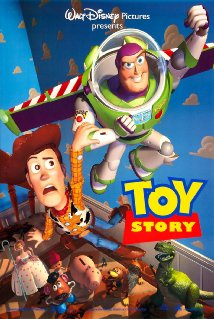

In [304]:
Image(title.cover_url)

In [305]:
print(title.title)
print(title.year)
print(title.genres)
print(title.release_date)

Toy Story
1995
['Animation', 'Adventure', 'Comedy', 'Family', 'Fantasy']
1995-11-22


In [306]:
cast = title.cast_summary
for person in cast:
    print(person.name)

Tom Hanks
Tim Allen
Don Rickles
Jim Varney


In [324]:
reviews = imdb.get_title_reviews(imdbid, max_results=2)


In [326]:
for review in reviews:
    print("Review by %s" % review.username)
    if(review.rating is not None):
        print("Rating: %.1f" % review.rating)
    print("Review: %s" % review.text)
    print()

Review by Philip Van der Veken
Rating: 9.0
Review: I am a big fan of the animated movies coming from the Pixar Studios. They are always looking for the newest technological possibilities to use in their movies, creating movies that are more than just worth a watch, even when they were made a decade ago.

The movie is about toys that come to life when their owner is asleep or not in the same room. When the young boy's birthday is coming up, all the toys are nervous. They don't want to be ignored when the new one arrives. Woody the cowboy is their "leader" because he's the most popular one of them all. He's the only one that hasn't got to be afraid, but than a new favorite arrives ... Buzz Lightyear. He hates him and tries everything possible to get rid of him, but as the time passes by they learn to appreciate each other...

When you see Toy Story, you may think that the different human like characters (Woody the cowboy for instance) aren't always as perfect as we are used to see in tod

Basta acessar a página da API para ver todas as informações que podem ser retornadas a partir da API. 

Para finalizar vamos melhorar a nossa apresentação da recomendação utilizando a API do IMDb. 

Filmes recomendados para o usuário 1:
01 [5.6] To Be and to Have (Être et avoir) (2002)


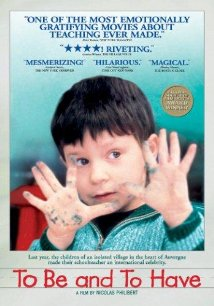

02 [5.6] Police Academy: Mission to Moscow (1994)


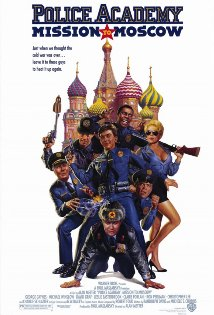

03 [5.6] Santa Clause 3: The Escape Clause, The (2006)


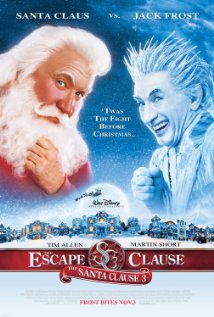

04 [5.4] Michael Jordan to the Max (2000)


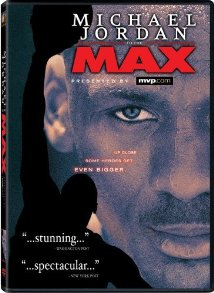

05 [5.4] Malibu's Most Wanted (2003)


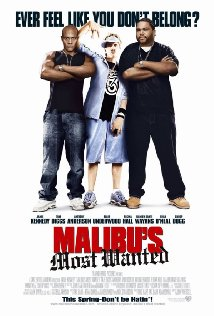

06 [5.4] Yu-Gi-Oh! (2004)


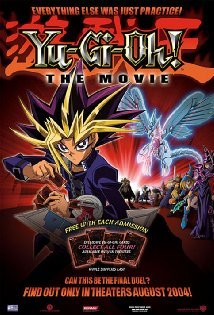

07 [5.4] Beastmaster 2: Through the Portal of Time (1991)


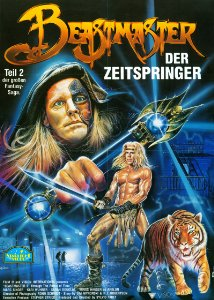

08 [5.4] Crossover (2006)


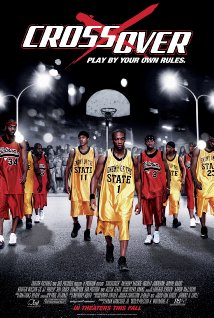

09 [5.4] Grudge 2, The (2006)


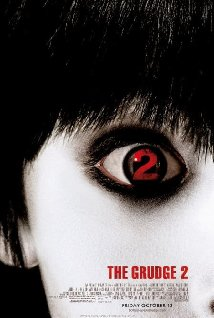

10 [5.4] Witless Protection (2008)


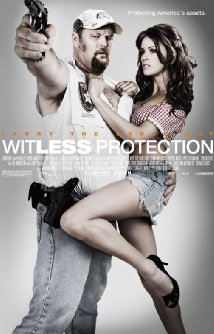

In [333]:
count = 1
top10 = sorted_items[:10]
print("Filmes recomendados para o usuário %s:" % user)
for movie in top10:
    imdbid = get_imdb_id(movie[0])
    print("%.2d" % count, "[%.1f]" % movie[1], get_movie_title(movie[0]), )
    if imdb.title_exists(imdbid):
        title = imdb.get_title_by_id(imdbid)
        display(Image(title.cover_url))
    count += 1

<a id='atividade'></a>
## Atividade do MiniProjeto

A atividade do MiniProjeto consiste em utilizar todo o conhecimento adquirido neste tutorial e propor um outro método de recomendação que de certa forma melhore ou traga algum ganho relevante ao método apresentado neste tutorial. Pesquise sobre a área e implemente tal solução. 